In [1]:
from config import *
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret_id))

In [2]:
song = pd.read_csv('../Data/raw/song_comp.csv')
song.head()

,song,artist,album_release_date
0,Supermodel (You Better Work),RuPaul,1993-06-08
1,We Break the Dawn,Michelle Williams,2008-04-15
2,The Greatest Love of All,Whitney Houston,1985-02-14
3,Would I Lie to You?,Eurythmics,1985-04-29
4,Stronger,Britney Spears,2000-05-16


In [3]:
song['release_year']=song['album_release_date'].apply(lambda x: str(x).split("-")[0])
song['release_decade'] = song['release_year'].apply(lambda x: 0 if x==0 else list(str(x))[2]+str(0))
song = song.drop(song.loc[song['release_decade']=='n0'].index)
song['release_decade'].value_counts(dropna=False)

song_decade = song.groupby(['release_decade','artist'],as_index=False).agg({'song':'count'})
song_decade

,release_decade,artist,song
0,00,(Mis-Teeq,1
1,00,Alicia Keys,1
2,00,Amy Winehouse,1
3,00,Anouk,1
4,00,Aretha Franklin,1
...,...,...,...
265,90,Thelma Houston,1
266,90,"Ultra Naté, Amber, Jocelyn Enriquez",1
267,90,Vengaboys,1
268,90,Whitney Houston,1


In [4]:
def decade_star(df): 
    decade_list = list(song_decade['release_decade'].unique())
    artist_list = []
    dec = []
    song_num = []
    for decade in decade_list: 
        max_song = df[(df['release_decade']==decade)]['song'].max()
        artist = list(df['artist'][(df['release_decade']==decade) & (df['song']==max_song)])[0]
        dec.append(decade)
        artist_list.append(artist)
        song_num.append(max_song)
    decade_dict = {'decade':dec,'artist of the decade':artist_list,'count':song_num}
    decade_df = pd.DataFrame.from_dict(decade_dict)
    return decade_df

decade_pd = decade_star(song_decade)
decade_pd = decade_pd.reindex([3,4,5,6,7,8,0,1,2]).reset_index(drop=True)
decade_pd

,decade,artist of the decade,count
0,40,Ethel Merman,1
1,50,Judy Garland,1
2,60,Aretha Franklin,3
3,70,Blondie,2
4,80,Janet Jackson,4
5,90,En Vogue,4
6,00,Britney Spears,6
7,10,RuPaul,9
8,20,Dua Lipa,4


In [5]:
def search_song(title,artist):
    try: 
        string = "tracks: " + title + "artist: " + artist
        song=sp.search(q=string,limit=1)
        id = song['tracks']['items'][0]['id']
    except:
        id = np.nan
    
    return id

In [6]:
song['id'] = list(map(search_song,song['song'],song['artist']))
song.head()

,song,artist,album_release_date,release_year,release_decade,id
0,Supermodel (You Better Work),RuPaul,1993-06-08,1993,90,36Rpz4MZQhGknLEmTmHr8v
1,We Break the Dawn,Michelle Williams,2008-04-15,2008,00,01drW5lmrI1SWrSkDzivsj
2,The Greatest Love of All,Whitney Houston,1985-02-14,1985,80,6yJxCltgtmGxIgKOS6ndnu
3,Would I Lie to You?,Eurythmics,1985-04-29,1985,80,1lJZSsMoWEbrgaY6CxPMf8
4,Stronger,Britney Spears,2000-05-16,2000,00,5QhBKPqsnX1uY9fZNaAtZg


In [7]:
display(song.shape)
song = song.dropna().reset_index(drop=True)
song.shape

(349, 6)

(346, 6)

In [8]:
def get_audio_features(list_of_songs_ids):
    features = sp.audio_features(list_of_songs_ids)
    return features

In [9]:
from time import sleep
from random import randint
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

song_id = list(song['id'])        
split_id = list(chunks(song_id,100))

In [10]:
audio=[]
for i in range(len(split_id)):
    audio.append(get_audio_features(list(split_id[i])))
    sleep(10)
    
data_total = pd.DataFrame()
data_list=[]
for i in audio:
    for j in i:
        d={}
        for key,val in j.items():
            d[key] = [val]
        data_total =pd.concat([data_total, pd.DataFrame(d)], axis=0)

data_total = data_total.reset_index(drop=True)
data_total = data_total.drop(columns='id')
song = pd.concat([song,data_total],axis=1)
display(song.isna().sum())
song.head()

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Supermodel (You Better Work),RuPaul,1993-06-08,1993,90,36Rpz4MZQhGknLEmTmHr8v,0.792,0.562,7,-11.379,...,0.000075,0.428,0.592,126.221,audio_features,spotify:track:36Rpz4MZQhGknLEmTmHr8v,https://api.spotify.com/v1/tracks/36Rpz4MZQhGk...,https://api.spotify.com/v1/audio-analysis/36Rp...,239933,4
1,We Break the Dawn,Michelle Williams,2008-04-15,2008,00,01drW5lmrI1SWrSkDzivsj,0.708,0.635,4,-5.304,...,0.000495,0.109,0.387,110.978,audio_features,spotify:track:01drW5lmrI1SWrSkDzivsj,https://api.spotify.com/v1/tracks/01drW5lmrI1S...,https://api.spotify.com/v1/audio-analysis/01dr...,236147,4
2,The Greatest Love of All,Whitney Houston,1985-02-14,1985,80,6yJxCltgtmGxIgKOS6ndnu,0.502,0.305,9,-16.011,...,0.000004,0.117,0.248,131.242,audio_features,spotify:track:6yJxCltgtmGxIgKOS6ndnu,https://api.spotify.com/v1/tracks/6yJxCltgtmGx...,https://api.spotify.com/v1/audio-analysis/6yJx...,291400,4
3,Would I Lie to You?,Eurythmics,1985-04-29,1985,80,1lJZSsMoWEbrgaY6CxPMf8,0.613,0.912,2,-4.638,...,0.000036,0.520,0.733,131.968,audio_features,spotify:track:1lJZSsMoWEbrgaY6CxPMf8,https://api.spotify.com/v1/tracks/1lJZSsMoWEbr...,https://api.spotify.com/v1/audio-analysis/1lJZ...,268240,4
4,Stronger,Britney Spears,2000-05-16,2000,00,5QhBKPqsnX1uY9fZNaAtZg,0.707,0.923,11,-3.957,...,0.000437,0.273,0.842,108.049,audio_features,spotify:track:5QhBKPqsnX1uY9fZNaAtZg,https://api.spotify.com/v1/tracks/5QhBKPqsnX1u...,https://api.spotify.com/v1/audio-analysis/5QhB...,203000,4


In [11]:
from bs4 import BeautifulSoup
import requests

def scrape_hot100():    
    url = "https://www.billboard.com/charts/hot-100"
    response = requests.get(url)
    response.status_code
    soup = BeautifulSoup(response.content, "html.parser")
    soup_t = soup.select("li.o-chart-results-list__item.\/\/.lrv-u-flex-grow-1.lrv-u-flex.lrv-u-flex-direction-column.lrv-u-justify-content-center.lrv-u-border-b-1.u-border-b-0\@mobile-max.lrv-u-border-color-grey-light.lrv-u-padding-l-1\@mobile-max > h3")
    soup_a = soup.select("li.o-chart-results-list__item.\/\/.lrv-u-flex-grow-1.lrv-u-flex.lrv-u-flex-direction-column.lrv-u-justify-content-center.lrv-u-border-b-1.u-border-b-0\@mobile-max.lrv-u-border-color-grey-light.lrv-u-padding-l-1\@mobile-max > span")
    titles = []
    artists = []

    for i in range(len(soup_t)):
        titles.append(soup_t[i].get_text().replace("\n","").replace("\t",""))
        artists.append(soup_a[i].get_text().replace("\n","").replace("\t",""))
    top = pd.DataFrame({'Title':titles,'Artist':artists})
    
    top.to_csv('../Data/cleaned/hot100.csv',index=False)
    
    return top

In [12]:
hot = scrape_hot100()
hot.columns=['song','artist']

In [13]:
hot['album_release_date'] = '2023-01-01'
hot['release_year']=2023
hot['release_decade']=20

In [14]:
hot['id']=list(map(search_song,hot['song'],song['artist']))

split_title = list(chunks(hot['song'], 50))
split_artist = list(chunks(hot['artist'], 50))

hot_id=[]
for i in range(len(split_title)):
    for j in range(0,50):
        hot_id.append(search_song(list(split_title[i])[j],list(split_artist[i])[j]))
    sleep(10)

hot_features = get_audio_features(hot_id)
hot_ft = pd.DataFrame(data=[hot_features[i].values() for i in range(len(hot_features))],columns=hot_features[0].keys())
hot_ft.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.517,0.675,6,-5.382,1,0.0357,0.4590,0.000000,0.1510,0.518,203.853,audio_features,59uQI0PADDKeE6UZDTJEe8,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4
1,0.644,0.735,8,-5.747,1,0.0391,0.0521,0.144000,0.1610,0.418,88.980,audio_features,1Qrg8KqiBpW07V7PNxwwwL,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4
2,0.672,0.159,9,-8.760,0,0.0343,0.9620,0.000018,0.1060,0.117,113.218,audio_features,3MnewZrZDqej6thgEx3OB1,spotify:track:3MnewZrZDqej6thgEx3OB1,https://api.spotify.com/v1/tracks/3MnewZrZDqej...,https://api.spotify.com/v1/audio-analysis/3Mne...,210827,4
3,0.668,0.758,5,-5.176,0,0.0332,0.4830,0.000019,0.0837,0.834,147.989,audio_features,3dnP0JxCgygwQH9Gm7q7nb,spotify:track:3dnP0JxCgygwQH9Gm7q7nb,https://api.spotify.com/v1/tracks/3dnP0JxCgygw...,https://api.spotify.com/v1/audio-analysis/3dnP...,165671,3
4,0.801,0.806,11,-5.206,1,0.0381,0.3820,0.000669,0.1140,0.802,106.999,audio_features,0WtM2NBVQNNJLh6scP13H8,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4


In [15]:
hot_ft = hot_ft.drop(columns='id')
hot_all = pd.concat([hot,hot_ft],axis=1)
display(hot_all.shape)
display(hot_all.isna().sum())
hot_all.head()

(100, 23)

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    1
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Last Night,Morgan Wallen,2023-01-01,2023,20,2kRkndFdIh2PDDjB53N1CB,0.517,0.675,6,-5.382,...,0.000000,0.1510,0.518,203.853,audio_features,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4
1,Kill Bill,SZA,2023-01-01,2023,20,1Qrg8KqiBpW07V7PNxwwwL,0.644,0.735,8,-5.747,...,0.144000,0.1610,0.418,88.980,audio_features,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4
2,Flowers,Miley Cyrus,2023-01-01,2023,20,7o8y3eDRgyBHFSjgu5PLXZ,0.672,0.159,9,-8.760,...,0.000018,0.1060,0.117,113.218,audio_features,spotify:track:3MnewZrZDqej6thgEx3OB1,https://api.spotify.com/v1/tracks/3MnewZrZDqej...,https://api.spotify.com/v1/audio-analysis/3Mne...,210827,4
3,Ella Baila Sola,Eslabon Armado X Peso Pluma,2023-01-01,2023,20,3dnP0JxCgygwQH9Gm7q7nb,0.668,0.758,5,-5.176,...,0.000019,0.0837,0.834,147.989,audio_features,spotify:track:3dnP0JxCgygwQH9Gm7q7nb,https://api.spotify.com/v1/tracks/3dnP0JxCgygw...,https://api.spotify.com/v1/audio-analysis/3dnP...,165671,3
4,Calm Down,Rema & Selena Gomez,2023-01-01,2023,20,0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,...,0.000669,0.1140,0.802,106.999,audio_features,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4


In [16]:
hot_all.columns == song.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [17]:
song.to_csv('../Data/cleaned/lsfyl.csv',index=False)
hot_all.to_csv('../Data/cleaned/hot100_features.csv',index=False)

In [18]:
from sklearn.cluster import KMeans


hot = pd.read_csv('../Data/cleaned/hot100_features.csv')
not_hot=pd.read_csv('../Data/cleaned/lsfyl.csv')

In [19]:
not_hot.drop_duplicates(subset=['id'], keep='first', inplace=True, ignore_index=True)
display(not_hot.shape)
not_hot.tail()

(333, 23)

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
328,Let It Go,Alexandra Burke,2012-06-04,2012,10,7c9T1m1RrtAWopKQVvFC3D,0.747,0.613,8,-8.151,...,0.00364,0.2880,0.555,139.723,audio_features,spotify:track:7c9T1m1RrtAWopKQVvFC3D,https://api.spotify.com/v1/tracks/7c9T1m1RrtAW...,https://api.spotify.com/v1/audio-analysis/7c9T...,223642,4
329,Toy,Netta,2018-05-23,2018,10,6n2eIfLj0wOOUkUfNmYzlh,0.786,0.712,3,-5.349,...,0.00000,0.2360,0.795,130.144,audio_features,spotify:track:6n2eIfLj0wOOUkUfNmYzlh,https://api.spotify.com/v1/tracks/6n2eIfLj0wOO...,https://api.spotify.com/v1/audio-analysis/6n2e...,180231,4
330,Domino,Jessie J,2011-01-01,2011,10,6MAdEUilV2p9RQUqE5bMAK,0.757,0.547,7,-4.573,...,0.00000,0.0445,0.793,126.977,audio_features,spotify:track:6MAdEUilV2p9RQUqE5bMAK,https://api.spotify.com/v1/tracks/6MAdEUilV2p9...,https://api.spotify.com/v1/audio-analysis/6MAd...,231693,4
331,The Reflex,Duran Duran,1983-11-21,1983,80,4sz1Ng2Cgidfqqiy0pNL6R,0.554,0.888,0,-6.664,...,0.00000,0.2910,0.820,126.701,audio_features,spotify:track:4sz1Ng2Cgidfqqiy0pNL6R,https://api.spotify.com/v1/tracks/4sz1Ng2Cgidf...,https://api.spotify.com/v1/audio-analysis/4sz1...,267427,4
332,Supernova,Kylie Minogue,2020-11-06,2020,20,2kYDYNJcZyEADRXwoZgQUk,0.568,0.929,4,-3.274,...,0.16500,0.3900,0.557,124.000,audio_features,spotify:track:2kYDYNJcZyEADRXwoZgQUk,https://api.spotify.com/v1/tracks/2kYDYNJcZyEA...,https://api.spotify.com/v1/audio-analysis/2kYD...,197880,4


In [21]:
y_lst = ["Yes"]*100
hot['hot'] = y_lst
display(hot['hot'].isna().sum())
n_lst = ["No"]*333
not_hot['hot'] = n_lst
not_hot.isna().sum()

0

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
hot                   0
dtype: int64

In [22]:
data = pd.concat([hot,not_hot],axis=0)
data = data.reset_index(drop=True)

data.tail()

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot
428,Let It Go,Alexandra Burke,2012-06-04,2012,10,7c9T1m1RrtAWopKQVvFC3D,0.747,0.613,8,-8.151,...,0.2880,0.555,139.723,audio_features,spotify:track:7c9T1m1RrtAWopKQVvFC3D,https://api.spotify.com/v1/tracks/7c9T1m1RrtAW...,https://api.spotify.com/v1/audio-analysis/7c9T...,223642,4,No
429,Toy,Netta,2018-05-23,2018,10,6n2eIfLj0wOOUkUfNmYzlh,0.786,0.712,3,-5.349,...,0.2360,0.795,130.144,audio_features,spotify:track:6n2eIfLj0wOOUkUfNmYzlh,https://api.spotify.com/v1/tracks/6n2eIfLj0wOO...,https://api.spotify.com/v1/audio-analysis/6n2e...,180231,4,No
430,Domino,Jessie J,2011-01-01,2011,10,6MAdEUilV2p9RQUqE5bMAK,0.757,0.547,7,-4.573,...,0.0445,0.793,126.977,audio_features,spotify:track:6MAdEUilV2p9RQUqE5bMAK,https://api.spotify.com/v1/tracks/6MAdEUilV2p9...,https://api.spotify.com/v1/audio-analysis/6MAd...,231693,4,No
431,The Reflex,Duran Duran,1983-11-21,1983,80,4sz1Ng2Cgidfqqiy0pNL6R,0.554,0.888,0,-6.664,...,0.2910,0.820,126.701,audio_features,spotify:track:4sz1Ng2Cgidfqqiy0pNL6R,https://api.spotify.com/v1/tracks/4sz1Ng2Cgidf...,https://api.spotify.com/v1/audio-analysis/4sz1...,267427,4,No
432,Supernova,Kylie Minogue,2020-11-06,2020,20,2kYDYNJcZyEADRXwoZgQUk,0.568,0.929,4,-3.274,...,0.3900,0.557,124.000,audio_features,spotify:track:2kYDYNJcZyEADRXwoZgQUk,https://api.spotify.com/v1/tracks/2kYDYNJcZyEA...,https://api.spotify.com/v1/audio-analysis/2kYD...,197880,4,No


In [23]:
data_num = data.select_dtypes(np.number)
data_num.head()

X = data_num.drop(columns=["key","mode","duration_ms","time_signature"])
X.head()

import pickle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
filename = "../Scaler/scaler_clustering.pickle"

with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head()) 
print()
X_scaled_df.head()

,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2023,20,0.517,0.675,-5.382,0.0357,0.4590,0.000000,0.1510,0.518,203.853
1,2023,20,0.644,0.735,-5.747,0.0391,0.0521,0.144000,0.1610,0.418,88.980
2,2023,20,0.672,0.159,-8.760,0.0343,0.9620,0.000018,0.1060,0.117,113.218
3,2023,20,0.668,0.758,-5.176,0.0332,0.4830,0.000019,0.0837,0.834,147.989
4,2023,20,0.801,0.806,-5.206,0.0381,0.3820,0.000669,0.1140,0.802,106.999


,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1.084535,-0.415399,-1.242878,-0.237756,0.472527,-0.596829,1.440556,-0.228854,-0.314436,-0.420463,3.505644
1,1.084535,-0.415399,-0.245547,0.108599,0.342854,-0.555404,-0.545668,0.932687,-0.252632,-0.860764,-1.585788
2,1.084535,-0.415399,-0.025663,-3.216407,-0.727564,-0.613886,3.895878,-0.228706,-0.592555,-2.186070,-0.511505
3,1.084535,-0.415399,-0.057075,0.241368,0.545711,-0.627289,1.557709,-0.228701,-0.730378,0.970888,1.029625
4,1.084535,-0.415399,0.987375,0.518452,0.535053,-0.567588,1.064692,-0.223458,-0.543112,0.829992,-0.787145


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K = range(10,19)

inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                    verbose=1)
    filename = 'kmeans_' + str(k) + '.pickle'
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
        
        
    kmeans.fit(X_scaled_df)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))

Training a K-Means model with 10 clusters! 

Initialization complete
Iteration 0, inertia 3071.008649221741.
Iteration 1, inertia 2373.092162872363.
Iteration 2, inertia 2281.730381870662.
Iteration 3, inertia 2232.820072425267.
Iteration 4, inertia 2208.1936007470986.
Iteration 5, inertia 2196.2423730961727.
Iteration 6, inertia 2187.310890876624.
Iteration 7, inertia 2183.797777156841.
Iteration 8, inertia 2177.151035595716.
Iteration 9, inertia 2173.5166718545024.
Iteration 10, inertia 2169.2523459687886.
Iteration 11, inertia 2165.064668814499.
Iteration 12, inertia 2162.2995494125767.
Iteration 13, inertia 2159.8851154270524.
Iteration 14, inertia 2158.317875009667.
Iteration 15, inertia 2156.93862758155.
Iteration 16, inertia 2156.197460405193.
Iteration 17, inertia 2155.666739516869.
Iteration 18, inertia 2155.408090306561.
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 3270.928635505975.
Iteration 1, inertia 2381.155635988494.
Iterat

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 6, inertia 2217.761617773412.
Iteration 7, inertia 2216.5266062462138.
Iteration 8, inertia 2216.3405514734354.
Iteration 9, inertia 2215.625870218313.
Iteration 10, inertia 2214.722500321034.
Iteration 11, inertia 2213.1930325405415.
Iteration 12, inertia 2212.8083068048268.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 3129.016505149389.
Iteration 1, inertia 2279.293704997707.
Iteration 2, inertia 2209.436767306506.
Iteration 3, inertia 2182.657229696696.
Iteration 4, inertia 2171.1519908742102.
Iteration 5, inertia 2163.4249450012953.
Iteration 6, inertia 2159.7691396622067.
Iteration 7, inertia 2155.742697930009.
Iteration 8, inertia 2154.1926753383873.
Iteration 9, inertia 2152.4037069085584.
Iteration 10, inertia 2148.1610823463698.
Iteration 11, inertia 2144.4432205222547.
Iteration 12, inertia 2141.4984790076282.
Iteration 13, inertia 2140.3367848679372.
Iteration 14, inertia 2140.2420113699477.
Converged at iteration 14: 

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 10, inertia 2092.516451744457.
Iteration 11, inertia 2089.489020884537.
Iteration 12, inertia 2086.1233496276423.
Iteration 13, inertia 2084.8372496502575.
Iteration 14, inertia 2084.454768741564.
Iteration 15, inertia 2084.2056066644727.
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 3124.4787232033564.
Iteration 1, inertia 2250.028940442788.
Iteration 2, inertia 2128.4641424502393.
Iteration 3, inertia 2112.9955397880917.
Iteration 4, inertia 2109.847504260511.
Iteration 5, inertia 2108.0606302773267.
Iteration 6, inertia 2104.27234284243.
Iteration 7, inertia 2097.552297933273.
Iteration 8, inertia 2093.4552426859973.
Iteration 9, inertia 2090.6707000329257.
Iteration 10, inertia 2080.573052261859.
Iteration 11, inertia 2075.0252530759017.
Iteration 12, inertia 2071.9138700297526.
Iteration 13, inertia 2070.8943889447323.
Iteration 14, inertia 2070.8595466038014.
Converged at iteration 14: strict convergence.
Initialization comp

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 2817.1771167865186.
Iteration 1, inertia 2270.6863626187087.
Iteration 2, inertia 2188.3460260928296.
Iteration 3, inertia 2142.7446116301576.
Iteration 4, inertia 2121.8684736657005.
Iteration 5, inertia 2107.9267653747506.
Iteration 6, inertia 2088.984683668332.
Iteration 7, inertia 2079.452556335588.
Iteration 8, inertia 2071.667292012371.
Iteration 9, inertia 2066.445300592554.
Iteration 10, inertia 2061.852752752274.
Iteration 11, inertia 2056.747872493971.
Iteration 12, inertia 2047.9504206744523.
Iteration 13, inertia 2044.8722418278749.
Iteration 14, inertia 2044.4824173141533.
Iteration 15, inertia 2043.7313698067107.
Iteration 16, inertia 2039.3530698391526.
Iteration 17, inertia 2034.5878338986108.
Iteration 18, inertia 2031.8483796607775.
Iteration 19, inertia 2029.3879325182536.
Iteration 20, inertia 2026.2743037146927.
Iteration 21, inertia 2023.974704603131.
Iteration 22, inertia 2023.0399001316514.
Iteration 23, inertia 2022.

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 3, inertia 2016.3347167727618.
Iteration 4, inertia 2001.9661411423622.
Iteration 5, inertia 1997.2392367725452.
Iteration 6, inertia 1995.5570300633801.
Iteration 7, inertia 1994.786035664659.
Iteration 8, inertia 1994.617909380203.
Iteration 9, inertia 1994.1474721844945.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 2600.0889125512576.
Iteration 1, inertia 2111.264203059227.
Iteration 2, inertia 2014.208464148926.
Iteration 3, inertia 1972.7558710029828.
Iteration 4, inertia 1958.2938811711078.
Iteration 5, inertia 1947.127371540503.
Iteration 6, inertia 1941.585191818965.
Iteration 7, inertia 1937.8797558779079.
Iteration 8, inertia 1935.7104982818469.
Iteration 9, inertia 1935.0926309389702.
Iteration 10, inertia 1934.0142662694088.
Iteration 11, inertia 1933.367310281674.
Iteration 12, inertia 1932.7370662076796.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2677.905954901218.
Ite

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 5, inertia 1997.659778210323.
Iteration 6, inertia 1990.003076428055.
Iteration 7, inertia 1985.382861134004.
Iteration 8, inertia 1983.3467962007428.
Iteration 9, inertia 1981.0443392955226.
Iteration 10, inertia 1980.2750188604464.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 2684.3360472213126.
Iteration 1, inertia 2010.9843895367967.
Iteration 2, inertia 1953.9423237348772.
Iteration 3, inertia 1929.7286703919572.
Iteration 4, inertia 1919.3690621231067.
Iteration 5, inertia 1910.8946458672465.
Iteration 6, inertia 1904.7644561325849.
Iteration 7, inertia 1892.872297399903.
Iteration 8, inertia 1878.9144044515378.
Iteration 9, inertia 1869.74443619024.
Iteration 10, inertia 1866.8387668484447.
Iteration 11, inertia 1864.7847329619835.
Iteration 12, inertia 1864.0489060656414.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2790.415530145645.
Iteration 1, inertia 2061.355226280823.
I

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 6, inertia 1838.550603207737.
Iteration 7, inertia 1831.617344647212.
Iteration 8, inertia 1827.4651693828841.
Iteration 9, inertia 1826.5529615737566.
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 2650.6145504531514.
Iteration 1, inertia 2006.3988988087901.
Iteration 2, inertia 1914.296951982787.
Iteration 3, inertia 1885.8864752347424.
Iteration 4, inertia 1874.5300932885204.
Iteration 5, inertia 1866.2001417283846.
Iteration 6, inertia 1860.4469199643486.
Iteration 7, inertia 1857.3883838667184.
Iteration 8, inertia 1854.8728507152991.
Iteration 9, inertia 1853.604865438254.
Iteration 10, inertia 1851.6359677846572.
Iteration 11, inertia 1849.7017301385242.
Iteration 12, inertia 1847.537437921159.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 2706.626823930136.
Iteration 1, inertia 2071.2159099199657.
Iteration 2, inertia 1953.9327885071652.
Iteration 3, inertia 1901.3061669275376.
I

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 29, inertia 1779.3905857275038.
Iteration 30, inertia 1779.257709452365.
Converged at iteration 30: strict convergence.
Initialization complete
Iteration 0, inertia 2524.9499518140574.
Iteration 1, inertia 1979.8962290074096.
Iteration 2, inertia 1884.5569037060238.
Iteration 3, inertia 1838.8771259225643.
Iteration 4, inertia 1831.5507293594253.
Iteration 5, inertia 1827.4526923275973.
Iteration 6, inertia 1824.7719573621187.
Iteration 7, inertia 1822.5147091914343.
Iteration 8, inertia 1821.598551176217.
Iteration 9, inertia 1820.2084508642706.
Iteration 10, inertia 1818.4005529838632.
Iteration 11, inertia 1816.9534371100035.
Iteration 12, inertia 1816.7848503613493.
Iteration 13, inertia 1816.5138810204205.
Iteration 14, inertia 1816.2147520845306.
Iteration 15, inertia 1815.855625240198.
Iteration 16, inertia 1815.5927236250357.
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 2465.7101451652525.
Iteration 1, inertia 1884.550009

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 2393.6584837347773.
Iteration 1, inertia 1959.370135300033.
Iteration 2, inertia 1868.4315336020854.
Iteration 3, inertia 1808.5166471168245.
Iteration 4, inertia 1780.2314176588195.
Iteration 5, inertia 1773.0737576749227.
Iteration 6, inertia 1769.7395307830068.
Iteration 7, inertia 1765.0557650452288.
Iteration 8, inertia 1757.1022380093818.
Iteration 9, inertia 1756.0274735958546.
Iteration 10, inertia 1752.9222959731844.
Iteration 11, inertia 1745.9811192321843.
Iteration 12, inertia 1742.78845385678.
Iteration 13, inertia 1741.4439269493932.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 2429.958742630619.
Iteration 1, inertia 1842.5991769228056.
Iteration 2, inertia 1752.2322459606532.
Iteration 3, inertia 1725.1246602982521.
Iteration 4, inertia 1717.8794726566382.
Iteration 5, inertia 1714.937203550913.
Iteration 6, inertia 1712.9622814442191.
Iteration 7, inertia 1712.3721529984432.
Iter

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Iteration 4, inertia 1711.2096105975463.
Iteration 5, inertia 1705.203391126958.
Iteration 6, inertia 1701.0290128602323.
Iteration 7, inertia 1699.6006840998475.
Iteration 8, inertia 1699.363918287811.
Iteration 9, inertia 1698.4582065831105.
Iteration 10, inertia 1698.1354781170653.
Converged at iteration 10: strict convergence.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

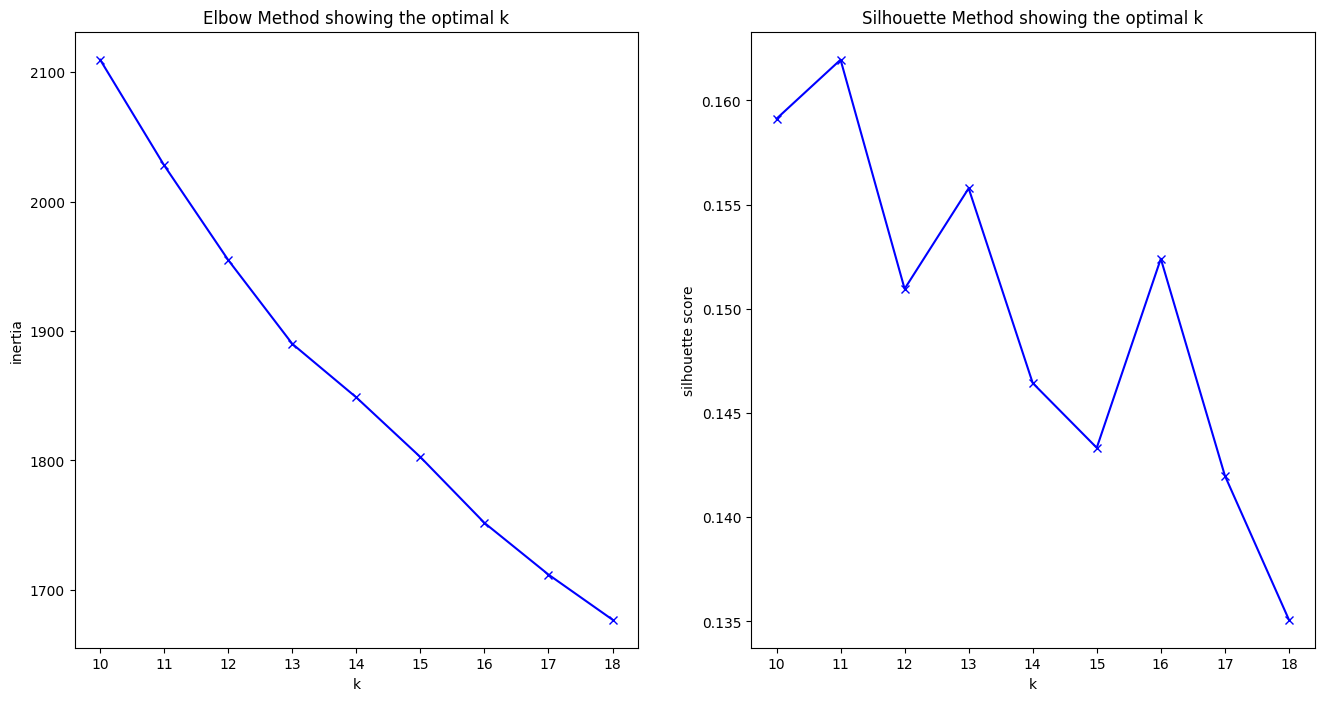

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

In [26]:
def load(filename = "filename.pickle"): 
    try: 
        with open(filename, "rb") as file: 
            return pickle.load(file) 
    except FileNotFoundError: 
        print("File not found!") 

In [27]:
best_model = load("../Models/kmeans_11.pickle")
best_model.fit(X_scaled_df)
clusters = best_model.predict(X_scaled_df)

X_scaled_df['cluster'] = clusters 
display(X_scaled_df.head())
X_scaled_df['cluster'].value_counts()

C:\Users\user\Desktop\Ironhack\Week_9\Final_project\final_term\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization complete
Iteration 0, inertia 2967.2861499970522.
Iteration 1, inertia 2316.599806000161.
Iteration 2, inertia 2213.360650089782.
Iteration 3, inertia 2155.6647973143095.
Iteration 4, inertia 2130.6555138227254.
Iteration 5, inertia 2117.9161496994525.
Iteration 6, inertia 2100.1504459197054.
Iteration 7, inertia 2092.713866033959.
Iteration 8, inertia 2081.746958941118.
Iteration 9, inertia 2076.5094669028863.
Iteration 10, inertia 2072.1652494151117.
Iteration 11, inertia 2066.3740717654478.
Iteration 12, inertia 2059.9429948126717.
Iteration 13, inertia 2057.827448276278.
Iteration 14, inertia 2056.80729110614.
Iteration 15, inertia 2056.2193537272015.
Iteration 16, inertia 2054.702238986588.
Iteration 17, inertia 2052.9379662703477.
Iteration 18, inertia 2052.568773280133.
Iteration 19, inertia 2051.6204776360246.
Iteration 20, inertia 2051.2632994788523.
Converged at iteration 20: strict convergence.
Initialization complete
Iteration 0, inertia 3112.609382418472.
It

,release_year,release_decade,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,1.084535,-0.415399,-1.242878,-0.237756,0.472527,-0.596829,1.440556,-0.228854,-0.314436,-0.420463,3.505644,3
1,1.084535,-0.415399,-0.245547,0.108599,0.342854,-0.555404,-0.545668,0.932687,-0.252632,-0.860764,-1.585788,9
2,1.084535,-0.415399,-0.025663,-3.216407,-0.727564,-0.613886,3.895878,-0.228706,-0.592555,-2.186070,-0.511505,6
3,1.084535,-0.415399,-0.057075,0.241368,0.545711,-0.627289,1.557709,-0.228701,-0.730378,0.970888,1.029625,3
4,1.084535,-0.415399,0.987375,0.518452,0.535053,-0.567588,1.064692,-0.223458,-0.543112,0.829992,-0.787145,5


cluster
5     99
9     65
10    54
4     48
2     39
3     37
1     32
0     25
6     20
7      9
8      5
Name: count, dtype: int64

In [28]:
data['cluster'] = X_scaled_df['cluster']
display(data.isna().sum())
data.head()

song                  0
artist                0
album_release_date    0
release_year          0
release_decade        0
id                    1
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
type                  0
uri                   0
track_href            0
analysis_url          0
duration_ms           0
time_signature        0
hot                   0
cluster               0
dtype: int64

,song,artist,album_release_date,release_year,release_decade,id,danceability,energy,key,loudness,...,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,hot,cluster
0,Last Night,Morgan Wallen,2023-01-01,2023,20,2kRkndFdIh2PDDjB53N1CB,0.517,0.675,6,-5.382,...,0.518,203.853,audio_features,spotify:track:59uQI0PADDKeE6UZDTJEe8,https://api.spotify.com/v1/tracks/59uQI0PADDKe...,https://api.spotify.com/v1/audio-analysis/59uQ...,163855,4,Yes,3
1,Kill Bill,SZA,2023-01-01,2023,20,1Qrg8KqiBpW07V7PNxwwwL,0.644,0.735,8,-5.747,...,0.418,88.980,audio_features,spotify:track:1Qrg8KqiBpW07V7PNxwwwL,https://api.spotify.com/v1/tracks/1Qrg8KqiBpW0...,https://api.spotify.com/v1/audio-analysis/1Qrg...,153947,4,Yes,9
2,Flowers,Miley Cyrus,2023-01-01,2023,20,7o8y3eDRgyBHFSjgu5PLXZ,0.672,0.159,9,-8.760,...,0.117,113.218,audio_features,spotify:track:3MnewZrZDqej6thgEx3OB1,https://api.spotify.com/v1/tracks/3MnewZrZDqej...,https://api.spotify.com/v1/audio-analysis/3Mne...,210827,4,Yes,6
3,Ella Baila Sola,Eslabon Armado X Peso Pluma,2023-01-01,2023,20,3dnP0JxCgygwQH9Gm7q7nb,0.668,0.758,5,-5.176,...,0.834,147.989,audio_features,spotify:track:3dnP0JxCgygwQH9Gm7q7nb,https://api.spotify.com/v1/tracks/3dnP0JxCgygw...,https://api.spotify.com/v1/audio-analysis/3dnP...,165671,3,Yes,3
4,Calm Down,Rema & Selena Gomez,2023-01-01,2023,20,0WtM2NBVQNNJLh6scP13H8,0.801,0.806,11,-5.206,...,0.802,106.999,audio_features,spotify:track:0WtM2NBVQNNJLh6scP13H8,https://api.spotify.com/v1/tracks/0WtM2NBVQNNJ...,https://api.spotify.com/v1/audio-analysis/0WtM...,239318,4,Yes,5


In [29]:
data.to_csv('../Data/cleaned/song_cluster.csv',index=False)